# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).




In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link='https://drive.google.com/open?id=1Ep6BVj98I3IoNrLgn8jhCCNbM66-IvUC'

In [3]:
fluff, id = link.split('=')
print(id) # Verify that you have everything after '='

1Ep6BVj98I3IoNrLgn8jhCCNbM66-IvUC


In [0]:
import pandas as pd
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Reviews.csv')  

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report,roc_auc_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import numpy
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

D:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
df= pd.read_csv("../amazon-fine-food-reviews/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = df[df['Score'] != 3]

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
filtered_data['Score'] = filtered_data['Score'].map(partition)

In [4]:
#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

#It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

# Removing rows where HelpfulnessNumerator is greater than HelpfulnessDenominator
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [5]:
import nltk
nltk.download('stopwords')
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))    
    

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
{'into', 'below', 'once', 'those', "shouldn't", "don't", 'are', 'for', 'against', 'down', "hadn't", 'myself', 'this', 'that', 'have', 'i', 'he', 'other', "it's", "you've", 'so', 'itself', 'y', 'be', 'themselves', 'aren', 'will', 'been', 'nor', 'is', "that'll", 'how', 'did', 'both', 'before', 'from', 'no', 'your', 'or', 'her', 'does', "hasn't", 'in', 'they', 'but', 'ma', 'herself', 'few', 'then', 'now', 't', "you'd", "mustn't",

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\badre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
#if not os.path.isfile('final.sqlite'):
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in tqdm(final['Text'].values):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")

    final_string.append(str1)
    i+=1

final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [08:21<00:00, 725.99it/s]


In [7]:
final.head(3) #below the processed review can be seen in the CleanedText Column 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


In [8]:
# Sorting data based on time
final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final = final.sort_values(by = "Time")
# Taking 50,000 sample points for brute force and 20,000 for kd-tree
#df1_b = final[final['Score']==1].sample(n=25000)
#df0_b = final[final['Score']==0].sample(n=25000)
#final_np_b=pd.concat([df1_b,df0_b])
 
#df1_k = final[final['Score']==1].sample(n=10000)
#df0_k = final[final['Score']==0].sample(n=10000)
#final_np_k=pd.concat([df1_k,df0_k])

In [9]:
final_np_b=final.head(60000)
final_np_k=final.head(30000)

## Optimal K value for KNN and ROC,AUC, Confusion Matrix

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix


def optimal_k_brute(X_train_vect,y_train,X_test_vect,y_test):
    train_auc = []
    test_auc = []
    K = [1, 5, 10, 15, 21, 31, 41, 51]
    for i in K:
        neigh = KNeighborsClassifier(n_neighbors=i,algorithm="brute")
        neigh.fit(X_train_vect, y_train)
        # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
        # not the predicted outputs
        y_train_pred =  neigh.predict_proba(X_train_vect)[:,1]
        y_test_pred =  neigh.predict_proba(X_test_vect)[:,1]

        train_auc.append(roc_auc_score(y_train,y_train_pred))
        test_auc.append(roc_auc_score(y_test, y_test_pred))

    plt.plot(K, train_auc, label='Train AUC')
    plt.plot(K, test_auc, label='Test AUC')
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()


def optimal_k_kdtree(X_train_vect,y_train,X_test_vect,y_test):
    train_auc = []
    test_auc = []
    K = [1, 5, 10, 15, 21, 31, 41, 51]
    for i in K:
        neigh = KNeighborsClassifier(n_neighbors=i,algorithm="kd_tree")
        neigh.fit(X_train_vect, y_train)
        # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
        # not the predicted outputs
        y_train_pred =  neigh.predict_proba(X_train_vect)[:,1]
        y_test_pred =  neigh.predict_proba(X_test_vect)[:,1]
    
        train_auc.append(roc_auc_score(y_train,y_train_pred))
        test_auc.append(roc_auc_score(y_test, y_test_pred))

    plt.plot(K, train_auc, label='Train AUC')
    plt.plot(K, test_auc, label='Test AUC')
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()

def roc_curve_brute(best_k,X_train_vect,y_train,X_test_vect,y_test):
    neigh = KNeighborsClassifier(n_neighbors=best_k,algorithm="brute")
    neigh.fit(X_train_vect, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_vect)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_vect)[:,1])

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show();

    print("="*100)

    print("Train confusion matrix")
    print(confusion_matrix(y_train, neigh.predict(X_train_vect)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, neigh.predict(X_test_vect)))
    
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(confusion_matrix(y_train, neigh.predict(X_train_vect)), index=class_label,columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix for Train")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show();
    
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(confusion_matrix(y_test, neigh.predict(X_test_vect)), index=class_label,columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix for Test")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show();
    
    
def roc_curve_kdtree(best_k,X_train_vect,y_train,X_test_vect,y_test):
    neigh = KNeighborsClassifier(n_neighbors=best_k,algorithm="kd_tree")
    neigh.fit(X_train_vect, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_vect)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_vect)[:,1])

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show();

    print("="*100)

    print("Train confusion matrix")
    print(confusion_matrix(y_train, neigh.predict(X_train_vect)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, neigh.predict(X_test_vect)))
    
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(confusion_matrix(y_train, neigh.predict(X_train_vect)), index=class_label,columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix for Train")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show();
    
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(confusion_matrix(y_test, neigh.predict(X_test_vect)), index=class_label,columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix for Test")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show();
    

### Train Test Split for Brute Force

In [11]:
# Train Label
X_b = final_np_b["CleanedText"]
print("shape of X:", X_b.shape)

shape of X: (60000,)


In [12]:
# Class label
y_b = final_np_b["Score"]
print("shape of y:", y_b.shape)

shape of y: (60000,)


In [13]:
from sklearn.model_selection import train_test_split
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size = 0.3, random_state = 42)
print(X_train_b.shape, y_train_b.shape, X_test_b.shape)

(42000,) (42000,) (18000,)


In [ ]:
sm = SMOTE(random_state=42)
X_train_b, y_train_b = sm.fit_sample(X_train_b, y_train_b.ravel())

### Train Test Split for Kd Tree

In [14]:
# Train Label
X_k = final_np_k["CleanedText"]
print("shape of X:", X_k.shape)

shape of X: (30000,)


In [15]:
# Class label
y_k = final_np_k["Score"]
print("shape of y:", y_k.shape)

shape of y: (30000,)


In [16]:
from sklearn.model_selection import train_test_split
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_k, y_k, test_size = 0.3, random_state = 42)
print(X_train_k.shape, y_train_k.shape, X_test_k.shape)

(21000,) (21000,) (9000,)


In [ ]:
sm = SMOTE(random_state=42)
X_train_k, y_train_k = sm.fit_sample(X_train_k, y_train_k.ravel())

# [7.2.2] Bag of Words (BoW)

In [17]:
#BoW
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(max_features=5000, min_df=10)
X_train=count_vect.fit_transform(X_train_b)

In [18]:
X_test=count_vect.transform(X_test_b)

In [19]:
sm = SMOTE(random_state=42)
X_train, y_train_bw = sm.fit_sample(X_train, y_train_b.ravel())

# Brute Force Algorithm

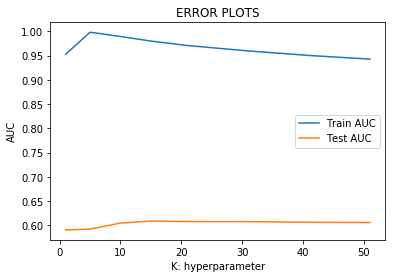

In [20]:
optimal_k_brute(X_train, y_train_bw,X_test,y_test_b)

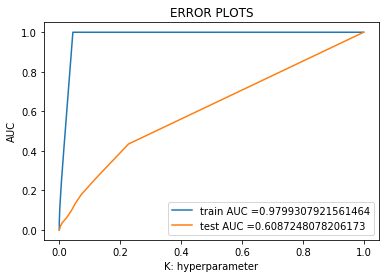

Train confusion matrix
[[37190    14]
 [35096  2108]]
Test confusion matrix
[[ 2024    33]
 [15192   751]]


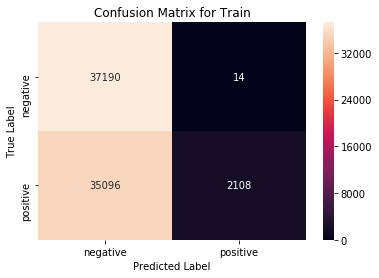

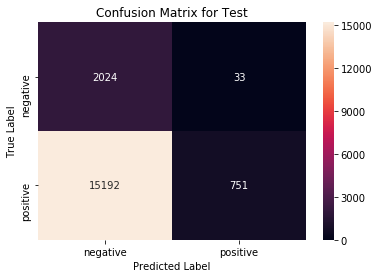

In [21]:
roc_curve_brute(15,X_train,y_train_bw,X_test,y_test_b)

# Kd_Tree Algorithm

In [22]:
#BoW
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(max_features=5000, min_df=10)
X_train=count_vect.fit_transform(X_train_k)

In [23]:
X_test=count_vect.transform(X_test_k)

In [24]:
sm = SMOTE(random_state=42)
X_train, y_train_kw = sm.fit_sample(X_train, y_train_k.ravel())

In [25]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
X_train = csr_matrix(X_train)
X_test = csr_matrix(X_test)
tsvd = TruncatedSVD(n_components=2)
X_train = tsvd.fit_transform(X_train)
X_test = tsvd.fit_transform(X_test)

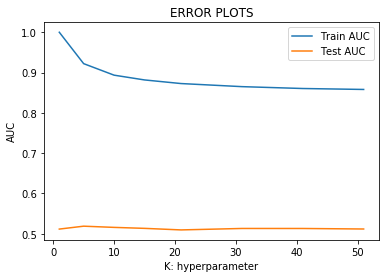

In [26]:
optimal_k_kdtree(X_train, y_train_kw,X_test,y_test_k)

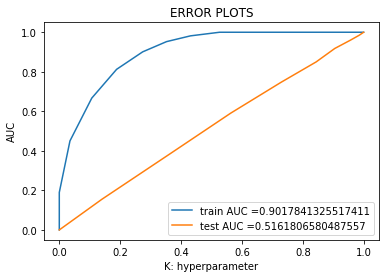

Train confusion matrix
[[15211  3530]
 [ 3515 15226]]
Test confusion matrix
[[ 266  714]
 [2031 5989]]


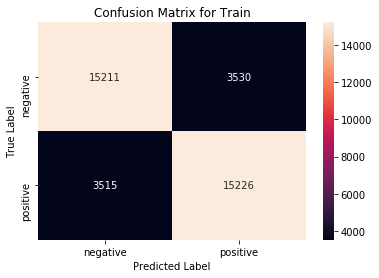

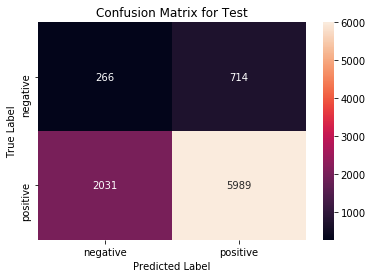

In [27]:
roc_curve_kdtree(8,X_train,y_train_kw,X_test,y_test_k)

## [7.2.4] Bi-Grams and n-Grams.

**Motivation**

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [28]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))


Most Common Positive Words :  [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most Common Negative Words :  [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [79]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2), max_features=5000,min_df=10) #in scikit-learn
X_train = count_vect.fit_transform(X_train_b)
X_train

<42000x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 1358164 stored elements in Compressed Sparse Row format>

In [80]:
X_test=count_vect.transform(X_test_b)

In [81]:
X_train.shape,y_train_b.shape

((42000, 5000), (42000,))

In [82]:
sm = SMOTE(random_state=42)
X_train, y_train_bw = sm.fit_sample(X_train, y_train_b.ravel())

# Brute Force Algorithm

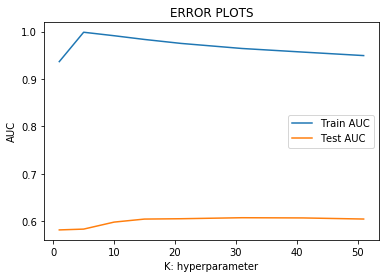

In [83]:
optimal_k_brute(X_train, y_train_bw,X_test,y_test_b)

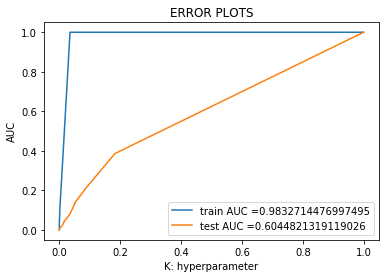

Train confusion matrix
[[37191    13]
 [35729  1475]]
Test confusion matrix
[[ 2029    28]
 [15406   537]]


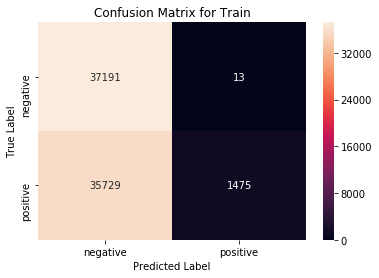

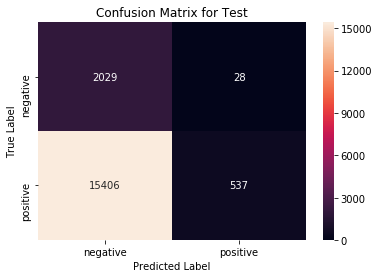

In [84]:
roc_curve_brute(15,X_train,y_train_bw,X_test,y_test_b)

# Kd_Tree Algorithm

In [34]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2), max_features=5000,min_df=10) #in scikit-learn
X_train = count_vect.fit_transform(X_train_k)
X_train

<21000x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 670793 stored elements in Compressed Sparse Row format>

In [35]:
X_test=count_vect.transform(X_test_k)

In [37]:
sm = SMOTE(random_state=42)
X_train, y_train_kw = sm.fit_sample(X_train, y_train_k.ravel())

In [38]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
X_train = csr_matrix(X_train)
X_test = csr_matrix(X_test)
tsvd = TruncatedSVD(n_components=2)
X_train = tsvd.fit_transform(X_train)
X_test = tsvd.fit_transform(X_test)

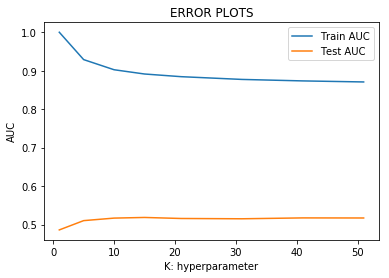

In [39]:
optimal_k_kdtree(X_train, y_train_kw,X_test,y_test_k)

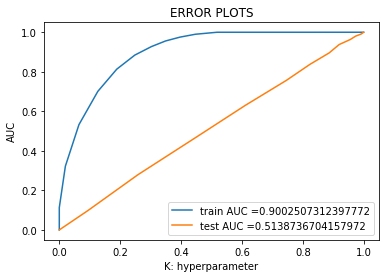

Train confusion matrix
[[14090  4651]
 [ 2165 16576]]
Test confusion matrix
[[ 173  807]
 [1303 6717]]


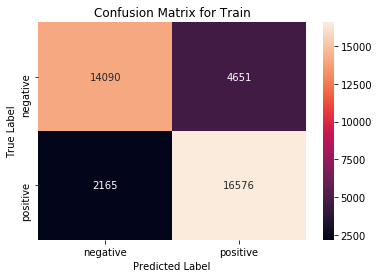

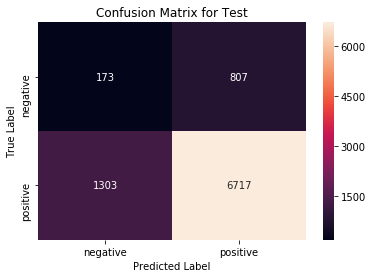

In [40]:
roc_curve_kdtree(11,X_train,y_train_kw,X_test,y_test_k)

# [7.2.5] TF-IDF

In [41]:
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train_b)
X_train

<42000x24716 sparse matrix of type '<class 'numpy.float64'>'
	with 1242314 stored elements in Compressed Sparse Row format>

In [42]:
X_test=tf_idf_vect.transform(X_test_b)

In [43]:
sm = SMOTE(random_state=42)
X_train, y_train_bw = sm.fit_sample(X_train, y_train_b.ravel())

# Brute Force Algorithm

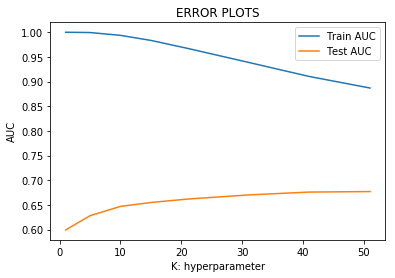

In [44]:
optimal_k_brute(X_train, y_train_bw,X_test,y_test_b)

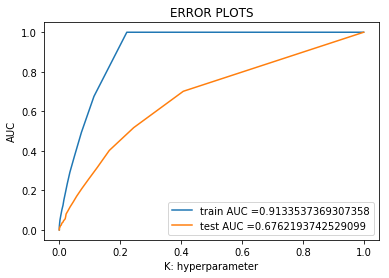

Train confusion matrix
[[37200     4]
 [36610   594]]
Test confusion matrix
[[ 2052     5]
 [15695   248]]


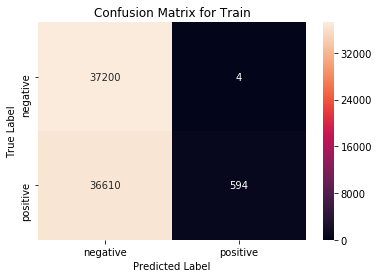

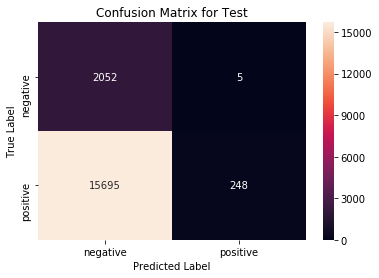

In [45]:
roc_curve_brute(40,X_train,y_train_bw,X_test,y_test_b)

# Kd_Tree Algorithm

In [46]:
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train_k)
X_train

<21000x18371 sparse matrix of type '<class 'numpy.float64'>'
	with 615827 stored elements in Compressed Sparse Row format>

In [47]:
X_test=tf_idf_vect.transform(X_test_k)

In [48]:
sm = SMOTE(random_state=42)
X_train, y_train_kw = sm.fit_sample(X_train, y_train_k.ravel())

In [49]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
X_train = csr_matrix(X_train)
X_test = csr_matrix(X_test)
tsvd = TruncatedSVD(n_components=2)
X_train = tsvd.fit_transform(X_train)
X_test = tsvd.fit_transform(X_test)

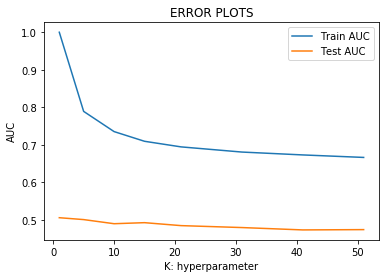

In [50]:
optimal_k_kdtree(X_train, y_train_kw,X_test,y_test_k)

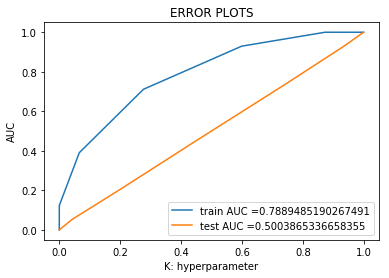

Train confusion matrix
[[13559  5182]
 [ 5408 13333]]
Test confusion matrix
[[ 525  455]
 [4286 3734]]


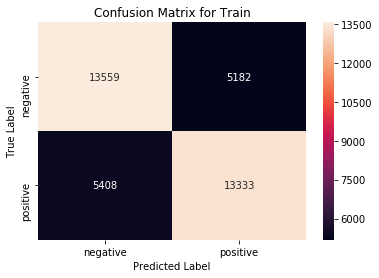

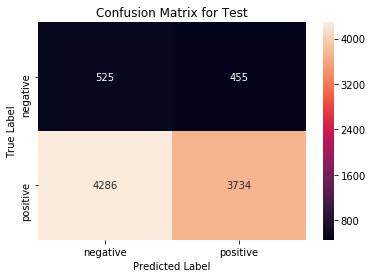

In [51]:
roc_curve_kdtree(5,X_train,y_train_kw,X_test,y_test_k)

# [7.2.6] Word2Vec

In [52]:
# List of sentence in X_train text
sent_of_train_b=[]
for sent in X_train_b:
    sent_of_train_b.append(sent.split())

# List of sentence in X_est text
sent_of_test_b=[]
for sent in X_test_b:
    sent_of_test_b.append(sent.split())   
    
w2v_dim=300    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model1=Word2Vec(sent_of_train_b,min_count=5,size=w2v_dim, workers=4)

w2v_model2=Word2Vec(sent_of_test_b,min_count=5,size=w2v_dim, workers=4)

w2v_words1 = list(w2v_model1.wv.vocab)

w2v_words2 = list(w2v_model2.wv.vocab)

# [7.2.7] Avg W2V, TFIDF-W2V

In [53]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train_b:
    sent_vec = np.zeros(w2v_dim) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words1:
            vec = w2v_model1.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test_b:
    sent_vec = np.zeros(w2v_dim) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words2:
            vec = w2v_model2.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec) 

X_train_avg_w2v_b = train_vectors
X_test_avg_w2v_b = test_vectors

In [54]:
#X_train_avg_w2v=X_train.copy()

In [55]:
#X_test_avg_w2v=X_test.copy()

In [56]:
sm = SMOTE(random_state=42)
X_train_avg_w2v_b, y_train_bw = sm.fit_sample(X_train_avg_w2v_b, y_train_b.ravel())

# Brute Force Algorithm

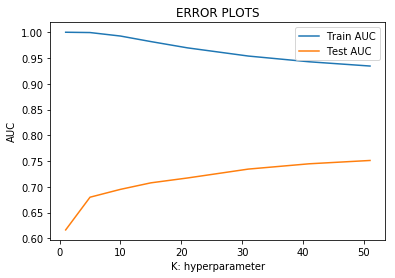

In [58]:
optimal_k_brute(X_train_avg_w2v_b, y_train_bw,X_test_avg_w2v_b,y_test_b)

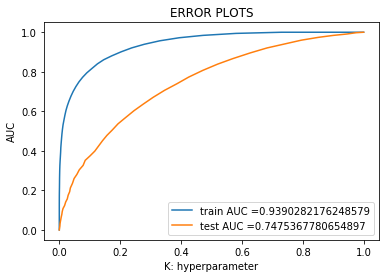

Train confusion matrix
[[36638   566]
 [16553 20651]]
Test confusion matrix
[[1792  265]
 [9184 6759]]


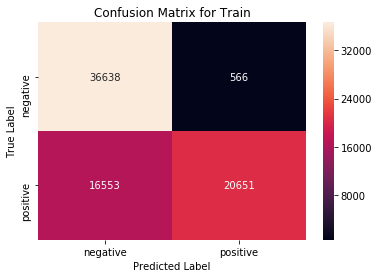

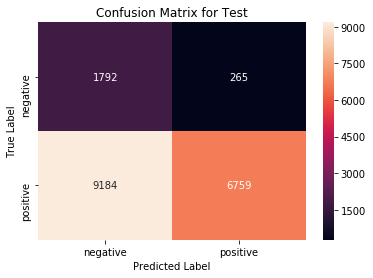

In [59]:
roc_curve_brute(45,X_train_avg_w2v_b,y_train_bw,X_test_avg_w2v_b,y_test_b)

# Kd_Tree Algorithm

In [60]:
# List of sentence in X_train text
sent_of_train_k=[]
for sent in X_train_k:
    sent_of_train_k.append(sent.split())

# List of sentence in X_est text
sent_of_test_k=[]
for sent in X_test_k:
    sent_of_test_k.append(sent.split())   
    
w2v_dim=300    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model1=Word2Vec(sent_of_train_k,min_count=5,size=w2v_dim, workers=4)

w2v_model2=Word2Vec(sent_of_test_k,min_count=5,size=w2v_dim, workers=4)

w2v_words1 = list(w2v_model1.wv.vocab)

w2v_words2 = list(w2v_model2.wv.vocab)

# [7.2.7] Avg W2V, TFIDF-W2V

In [61]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train_k:
    sent_vec = np.zeros(w2v_dim) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words1:
            vec = w2v_model1.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test_k:
    sent_vec = np.zeros(w2v_dim) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words2:
            vec = w2v_model2.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec) 

X_train_avg_w2v_k = train_vectors
X_test_avg_w2v_k = test_vectors

In [62]:
sm = SMOTE(random_state=42)
X_train_avg_w2v_k, y_train_kw = sm.fit_sample(X_train_avg_w2v_k, y_train_k.ravel())

In [63]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
X_train = csr_matrix(X_train_avg_w2v_k)
X_test = csr_matrix(X_test_avg_w2v_k)
tsvd = TruncatedSVD(n_components=2)
X_train = tsvd.fit_transform(X_train_avg_w2v_k)
X_test = tsvd.fit_transform(X_test_avg_w2v_k)

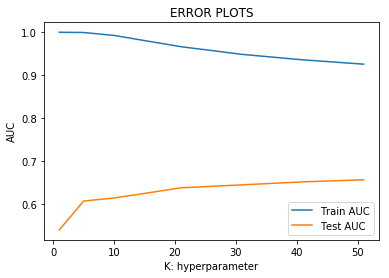

In [64]:
optimal_k_kdtree(X_train_avg_w2v_k, y_train_kw,X_test_avg_w2v_k,y_test_k)

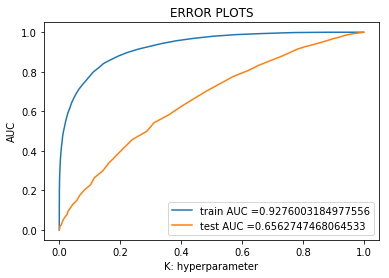

Train confusion matrix
[[18213   528]
 [ 7657 11084]]
Test confusion matrix
[[ 698  282]
 [4014 4006]]


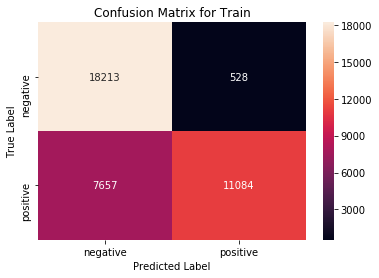

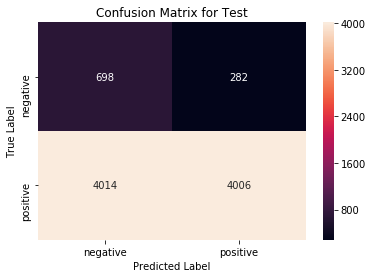

In [65]:
roc_curve_kdtree(49,X_train_avg_w2v_k,y_train_kw,X_test_avg_w2v_k,y_test_k)

# TFIDF-W2V

In [66]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final_np_b['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [67]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_train_b: # for each review/sentence 
    sent_vec = np.zeros(w2v_dim) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
            if word in w2v_words1:
                vec = w2v_model1.wv[word]
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [68]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_test_b: # for each review/sentence 
    sent_vec = np.zeros(w2v_dim) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
            if word in w2v_words2:
                vec = w2v_model2.wv[word]
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

X_train_tfidf_w2v_b = tfidf_sent_vectors
X_test_tfidf_w2v_b = tfidf_sent_vectors_test
#X_train_tfidf_w2v=X_train.copy()
#X_test_tfidf_w2v=X_test.copy()

In [69]:
sm = SMOTE(random_state=42)
X_train_tfidf_w2v_b, y_train_bw = sm.fit_sample(X_train_tfidf_w2v_b, y_train_b.ravel())

# Brute Force Algorithm

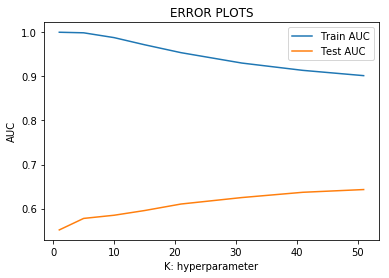

In [70]:
optimal_k_brute(X_train_tfidf_w2v_b, y_train_bw,X_test_tfidf_w2v_b,y_test_b)

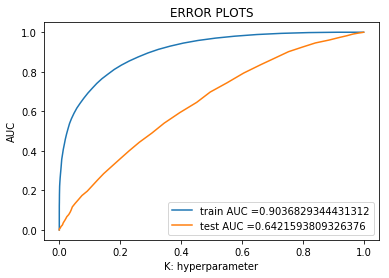

Train confusion matrix
[[35719  1485]
 [16271 20933]]
Test confusion matrix
[[ 1834   223]
 [12380  3563]]


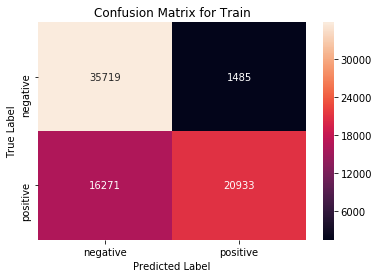

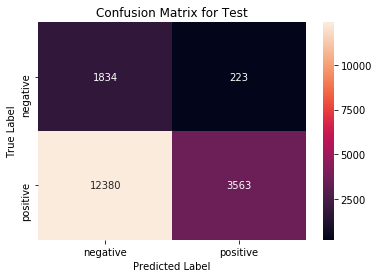

In [71]:
roc_curve_brute(49,X_train_tfidf_w2v_b,y_train_bw,X_test_tfidf_w2v_b,y_test_b)

# Kd_Tree Algorithm

In [72]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final_np_k['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [73]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_train_k: # for each review/sentence 
    sent_vec = np.zeros(w2v_dim) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
            if word in w2v_words1:
                vec = w2v_model1.wv[word]
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [74]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_test_k: # for each review/sentence 
    sent_vec = np.zeros(w2v_dim) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
            if word in w2v_words2:
                vec = w2v_model2.wv[word]
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

X_train_tfidf_w2v_k = tfidf_sent_vectors
X_test_tfidf_w2v_k = tfidf_sent_vectors_test

In [75]:
sm = SMOTE(random_state=42)
X_train_tfidf_w2v_k, y_train_kw = sm.fit_sample(X_train_tfidf_w2v_k, y_train_k.ravel())

In [76]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
X_train = csr_matrix(X_train_tfidf_w2v_k)
X_test = csr_matrix(X_test_tfidf_w2v_k)
tsvd = TruncatedSVD(n_components=2)
X_train = tsvd.fit_transform(X_train_tfidf_w2v_k)
X_test = tsvd.fit_transform(X_test_tfidf_w2v_k)

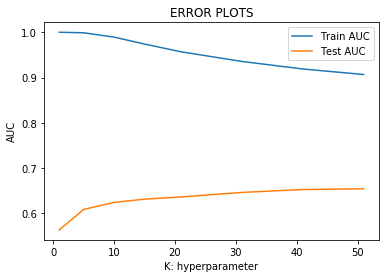

In [77]:
optimal_k_kdtree(X_train_tfidf_w2v_k, y_train_kw,X_test_tfidf_w2v_k,y_test_k)

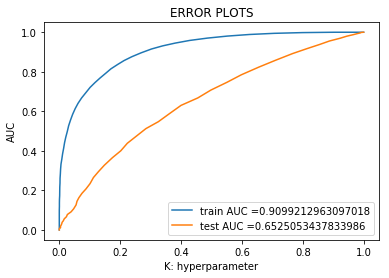

Train confusion matrix
[[18049   692]
 [ 8323 10418]]
Test confusion matrix
[[ 809  171]
 [5090 2930]]


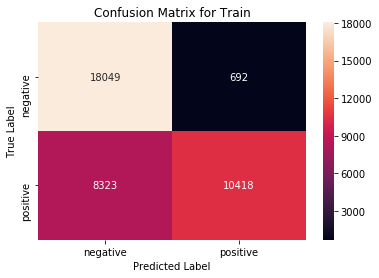

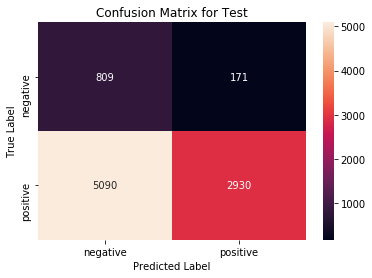

In [78]:
roc_curve_kdtree(48,X_train_tfidf_w2v_k,y_train_kw,X_test_tfidf_w2v_k,y_test_k)

In [85]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Vectorizer","Algorithm","k","Train AUC","Test error"]

x.add_row(["Unigram BOW", "Brute",15,0.97,0.60])
x.add_row(["Unigram BOW", "Kd-Tree",8,0.90,0.51])
x.add_row(["Bigram BOW", "Brute",15,0.98,0.60])
x.add_row(["Bigram BOW", "Kd-Tree",11,0.90,0.51])
x.add_row(["TF-IDF", "Brute",40,0.91,0.67])
x.add_row(["TF-IDF", "Kd-Tree",5,0.78,0.50])
x.add_row(["AVG-W2V", "Brute",45,0.93,0.74])
x.add_row(["AVG-W2V", "Kd-Tree",49,0.92,0.65])
x.add_row(["TFIDF-W2V", "Brute",49,0.90,0.64])
x.add_row(["TFIDF-W2V", "Kd-Tree",48,0.90,0.65])

print("Performance Table")
print(x)

Performance Table
+-------------+-----------+----+-----------+------------+
|  Vectorizer | Algorithm | k  | Train AUC | Test error |
+-------------+-----------+----+-----------+------------+
| Unigram BOW |   Brute   | 15 |    0.97   |    0.6     |
| Unigram BOW |  Kd-Tree  | 8  |    0.9    |    0.51    |
|  Bigram BOW |   Brute   | 15 |    0.98   |    0.6     |
|  Bigram BOW |  Kd-Tree  | 11 |    0.9    |    0.51    |
|    TF-IDF   |   Brute   | 40 |    0.91   |    0.67    |
|    TF-IDF   |  Kd-Tree  | 5  |    0.78   |    0.5     |
|   AVG-W2V   |   Brute   | 45 |    0.93   |    0.74    |
|   AVG-W2V   |  Kd-Tree  | 49 |    0.92   |    0.65    |
|  TFIDF-W2V  |   Brute   | 49 |    0.9    |    0.64    |
|  TFIDF-W2V  |  Kd-Tree  | 48 |    0.9    |    0.65    |
+-------------+-----------+----+-----------+------------+


## Summary
1. Loading Amazon Food Reviews Dataset
2. Ratings greater then 3 are taken as positive and less than as negative reviews
3. Text Preprocessing by removing Stopwords and Lemmatize words
4. Sampling 60,000 points for Brute Force Knn and 30,000 points for KdTree Knn
5. Optimal Functions for k in the algorithmns and Roc Curve
6. Vectorizing on Unigram BOW,Bigram BOW,TF-IDF,AVG-W2V,TFIDF-W2V 
7. Avg-w2v Brute Force gives the best result